In [1]:
import healpy as hp
from astropy.io import fits
import numpy as np
import matplotlib.pyplot as plt
import glob
import fitsio
import chainconsumer
from tqdm import tqdm

In [6]:
plt.rcParams["axes.linewidth"]  = 1.0
plt.rcParams["xtick.major.size"]  = 10
plt.rcParams["xtick.minor.size"]  = 5
plt.rcParams["ytick.major.size"]  = 10
plt.rcParams["ytick.minor.size"]  = 5
plt.rcParams["xtick.direction"]  = "in"
plt.rcParams["ytick.direction"]  = "in"
plt.rcParams["legend.frameon"] = 'False'
plt.rcParams['figure.figsize'] = [10, 10]
plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)


COLORS = ["f07167","219ebc","c767ac","E0A100","59a270"]
COLORS = ['#' + c if c[0] != '#' else c for c in COLORS ]

from cycler import cycler

# Update the default prop_cycle
plt.rcParams['axes.prop_cycle'] = cycler(color=COLORS)

# Read columns

In [3]:
metacal_columns = ['mcal_flux_noshear', 'mcal_T_noshear', 'mcal_T_ratio_noshear', 'mcal_s2n_noshear']

metacal_filelist = glob.glob('/project/chihway/dhayaa/DECADE/Tests/v08_RunDR3_Restart/metacal_*gplus.fits')[:500]

Tiles = [m.split('metacal_')[1][:12] for m in metacal_filelist]

Total_catalog = []

for f in tqdm(metacal_filelist):
    
    try:
        Total_catalog.append(fitsio.read(f, columns = metacal_columns))
    except:
        continue
    
Total_catalog_sim = np.concatenate(Total_catalog)



metacal_filelist = ['/project/chihway/data/decade/shearcat_final/metacal_output_%s.fits' % t for t in Tiles]

Total_catalog = []
for f in tqdm(metacal_filelist):
    
    try:
        Total_catalog.append(fitsio.read(f, columns = metacal_columns))
    except:
        continue
    
Total_catalog_data = np.concatenate(Total_catalog)

100%|██████████| 500/500 [02:59<00:00,  2.79it/s]


In [4]:
def postprocess(X):
    
    new_array = np.zeros(len(X), 
                         dtype = [('SNR', '>f8'), 
                                  ('T', '>f8'),
                                  ('r', '>f8'),
                                  ('r-i', '>f8'),
                                  ('r-z', '>f8')
                                 ])
    
    new_array['SNR'] = X['mcal_s2n_noshear']
    new_array['T'] = X['mcal_T_noshear']
    new_array['r'] = X['mcal_flux_noshear'][:, 0]    
    
    Mask = ((new_array['r'] > 0) & (new_array['SNR'] > 0) & (new_array['T'] > -1))
    
    new_array = new_array[Mask]    
    
    new_array['SNR'] = np.log10(new_array['SNR'])
    new_array['T']   = np.log10(1 + new_array['T'])
    new_array['r'] = 30 - 2.5*np.log10(new_array['r'])
    
    i = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 1])[Mask]
    z = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 2])[Mask]
    
    Mask = ((new_array['r'] < 40) & (new_array['r'] > 14) & (i < 40) & (z < 40) & (new_array['T'] < 4.5))
    
    new_array = new_array[Mask]   
    
    new_array['r-i'] = new_array['r'] - i[Mask]
    new_array['r-z'] = new_array['r'] - z[Mask]
    
    print("SIZE:", len(new_array))
    return new_array

def dtype_to_float(X, t = '>f8'):
    
    return X.view(t).reshape(-1, len(X.dtype.names))

/scratch/local/jobs/20216618/ipykernel_2418571/1563780814.py:23: RuntimeWarning: invalid value encountered in log10
  i = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 1])[Mask]
/scratch/local/jobs/20216618/ipykernel_2418571/1563780814.py:24: RuntimeWarning: invalid value encountered in log10
  z = 30 - 2.5*np.log10(X['mcal_flux_noshear'][:, 2])[Mask]


SIZE: 19947259
SIZE: 32000554


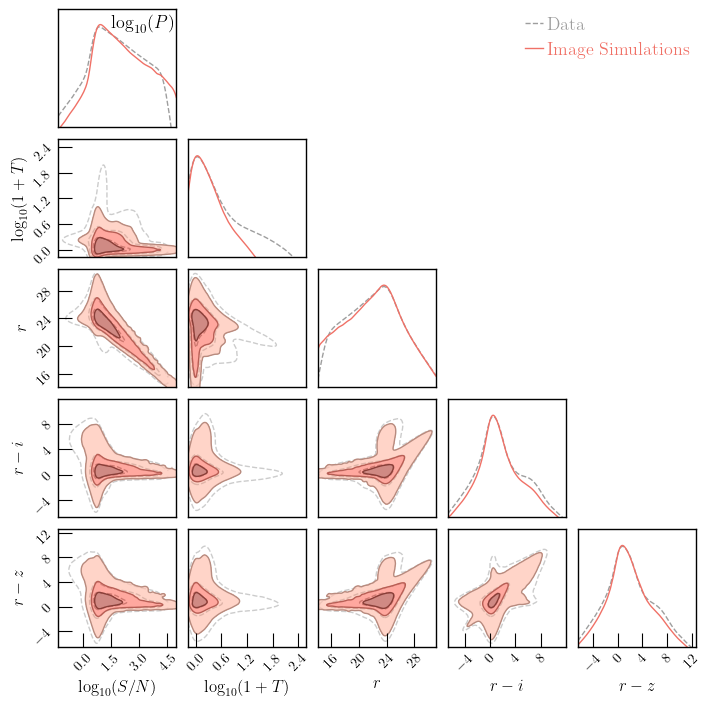

In [28]:
from chainconsumer import ChainConsumer

plt.rc('text', usetex=True)
plt.rc('font', family='serif', size=13)

param_names = [r"$\log_{10}(S/N)$", r"$\log_{10}(1 + T)$", 
               r"$r$", 
               r"$r-i$", 
               r"$r-z$"]
ranges = [(0.5, 2.5), 
          (-0.2, 0.4),
          (18, 30),
          (-4, 4),
          (-4, 4),]

c = ChainConsumer()

c.add_chain(dtype_to_float(postprocess(Total_catalog_data))[::1], parameters = param_names, name = 'Data')
c.add_chain(dtype_to_float(postprocess(Total_catalog_sim))[::1],  parameters = param_names, name = 'Image Simulations')

c.configure(sigmas = [0, 1, 2, 3], linewidths = 1, linestyles = ['--', '-'], spacing = 2, legend_kwargs = {'fontsize' : 13},
            colors=['grey', COLORS[0]], shade = [False, True], shade_alpha=[1.0, 0.7], bar_shade=False, usetex=True, serif=True)

fig = c.plotter.plot()

for i in range(0, 25, 6):
    fig.axes[i].set_yscale('log')
    yy = fig.axes[i].get_children()[0]._y
    fig.axes[i].set_ylim(np.max(yy) * 1e-4, np.max(yy) * 5)
    fig.axes[i].set_yticks([])
fig.axes[0].text(4.9, 0.8, r'$\log_{10}(P)$', ha = 'right', color = 'k', alpha = 1.0, size = 13) #, transform = fig.axes[6].transAxes)

plt.savefig('./Imsims_Triangle.pdf', dpi = 300, bbox_inches = 'tight')

# fig = c.plotter.plot(extents = ranges)